# Speaker classifier 
Using Keras and [free-spoken-digit-dataset](https://github.com/Jakobovski/free-spoken-digit-dataset)

## Loading data and Preprocessing

In [1]:
import os
import random
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn import model_selection

In [2]:
# Free vram
from numba import cuda 
device = cuda.get_current_device()
device.reset()
# Secure vram
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [3]:
# load wav data
def load_wav(audio_dir, file_name, sr):
    file_path = os.path.join(audio_dir, file_name)
    x, sr = librosa.load(file_path, sr=sr)
    return x, sr

# convert wav data to melspectrogram
def calculate_melsp(x, n_fft=1024, hop_length=128, sr=4000):
    stft = librosa.stft(x, n_fft=n_fft, hop_length=hop_length)
    log_stft = librosa.power_to_db(np.abs(stft)**2, ref=np.max)
    melsp = librosa.feature.melspectrogram(S=log_stft,n_mels=128)
    return melsp

# plot wave
def show_wav(x):
    plt.plot(x)
    plt.show()

# wave in heatmap
def show_melsp(melsp, sr):
    librosa.display.specshow(melsp, sr=sr)
    plt.colorbar()
    plt.show()

### Show sample data

wave size:(6316,)
melsp size:(128, 50)
sampling rate:8000


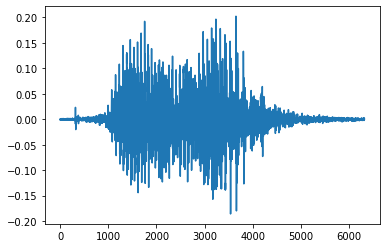

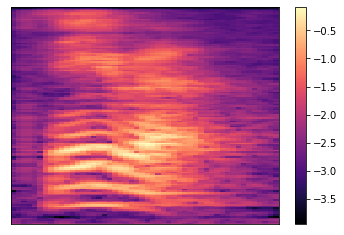

In [4]:
x, sr = load_wav('./my_voice/','0_0.wav', sr=8000)
melsp = calculate_melsp(x, sr=sr)
print(f'wave size:{x.shape}\nmelsp size:{melsp.shape}\nsampling rate:{sr}')
show_wav(x)
show_melsp(melsp, sr)

wave size:(4727,)
melsp size:(128, 37)
sampling rate:8000


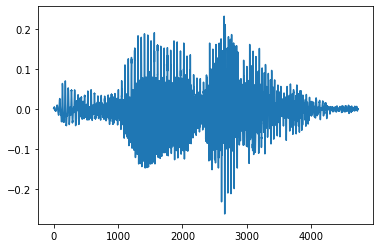

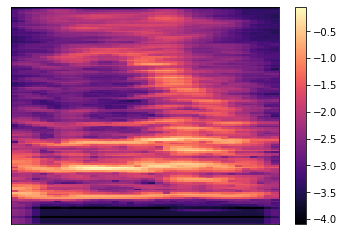

In [5]:
x, sr = load_wav('free-spoken-digit-dataset/recordings/','0_george_1.wav', sr=8000)
melsp = calculate_melsp(x, sr=sr)
print(f'wave size:{x.shape}\nmelsp size:{melsp.shape}\nsampling rate:{sr}')
show_wav(x)
show_melsp(melsp, sr)

### Get filenames and label all of them (one-hot)
My Voice will be labeled as 1 and others will be 0

In [6]:
# Get data from free-dataset
import random

DATA_SIZE = 3000
DEFAULT_SR = 8000

audio_dir_other = "./free-spoken-digit-dataset/recordings/"
path_list_others = os.listdir(audio_dir_other)
random.shuffle(path_list_others)

max_length = 0
others = []
for i in range(DATA_SIZE):
    tmp, sr = load_wav(audio_dir_other, path_list_others[i], DEFAULT_SR)
    others.append(tmp)
    
    if max_length < len(tmp):
        max_length = len(tmp)

In [7]:
# Get my voice
audio_dir_myvoice = "./my_voice/"
path_list_myvoice = os.listdir(audio_dir_myvoice)
random.shuffle(path_list_myvoice)

myvoice = []
for i in range(len(path_list_myvoice)):
    tmp, sr = load_wav(audio_dir_myvoice, path_list_myvoice[i], DEFAULT_SR)
    myvoice.append(tmp)
    
    if max_length < len(tmp):
        max_length = len(tmp)

In [8]:
def fix_length(data, max_length):
    tmp_array = []
    if len(data) != max_length:
        for i in range(len(data)):
            add_length = max_length - len(data[i])
            data[i] = np.append(data[i], np.zeros(add_length))
    return data

In [9]:
# Fix length to max length
others = fix_length(others, max_length)
myvoice = fix_length(myvoice, max_length)

In [10]:
# Get melsp
others_melsp = []
for i in range(len(others)):
    others_melsp.append(calculate_melsp(others[i]))

myvoice_melsp = []
for i in range(len(myvoice)):
    myvoice_melsp.append(calculate_melsp(myvoice[i]))

In [11]:
# Check both shapes
print(np.array(others_melsp).shape)
print(np.array(myvoice_melsp).shape)

(3000, 128, 143)
(100, 128, 143)


### Data expantion

In [12]:
# add white noise
def add_white_noise(x, rate=0.002):
    return x + rate*np.random.randn(len(x))

# timeshift
def shift_sound(x, rate=2):
    return np.roll(x, int(len(x)//rate))

# stretch
def stretch_sound(x, rate=1.1):
    input_length = len(x)
    x = librosa.effects.time_stretch(x, rate)
    if len(x)>input_length:
        return x[:input_length]
    else:
        return np.pad(x, (0, max(0, input_length - len(x))), "constant")

In [13]:
count = 0
for i in range(len(path_list_others)):
    if path_list_others[i].find("george") != -1:
        count += 1
print(count)

500


In [14]:
# Others voice with various effects
others_noise_melsp = []
others_shift_melsp = []
others_stretch_melsp = []
for i in range(len(others)):
        others_noise_melsp.append(calculate_melsp(add_white_noise(others[i])))
        others_shift_melsp.append(calculate_melsp(shift_sound(others[i])))
        others_stretch_melsp.append(calculate_melsp(stretch_sound(others[i])))

In [15]:
# My voice with various effects
myvoice_noise = []
myvoice_shift = []
myvoice_stretch = []

myvoice_noise_melsp = []
myvoice_shift_melsp = []
myvoice_stretch_melsp = []
for i in range(len(myvoice)):
    # make it 5 times bigger
    for j in range(5):
        # add effects on original wav
        myvoice_noise.append(add_white_noise(myvoice[i]))
        myvoice_shift.append(shift_sound(myvoice[i]))
        myvoice_stretch.append(stretch_sound(myvoice[i]))
    for j in range(5):   
        # translate to melsp
        myvoice_noise_melsp.append(calculate_melsp(myvoice_noise[i + j]))
        myvoice_shift_melsp.append(calculate_melsp(myvoice_shift[i + j]))
        myvoice_stretch_melsp.append(calculate_melsp(myvoice_stretch[i + j]))

In [16]:
# Size of my voice in total
(len(myvoice) * 6)*6 + len(myvoice)

3700

In [17]:
# Size of others in total
len(others) * 4

12000

In [18]:
X = []

X.extend(others_melsp)
X.extend(others_noise_melsp)
X.extend(others_shift_melsp)
X.extend(others_stretch_melsp)
label = np.zeros(len(others_melsp)
               +len(others_noise_melsp)
               +len(others_shift_melsp)
               +len(others_stretch_melsp))

X.extend(myvoice_melsp)
X.extend(myvoice_noise_melsp)
X.extend(myvoice_shift_melsp)
X.extend(myvoice_stretch_melsp)
label = np.append(label, np.ones(len(myvoice_melsp)
                             +len(myvoice_noise_melsp)
                             +len(myvoice_shift_melsp)
                             +len(myvoice_stretch_melsp)))

In [19]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(np.array(X), np.array(label), test_size=0.25, stratify=label, shuffle=True)

np.savez("train.npz", x=x_train, y=y_train)
np.savez("test.npz", x=x_train, y=y_train)

print(f'x_train:{x_train.shape}, y_train:{y_train.shape}')
print(f'x_test:{x_test.shape}, y_test:{y_test.shape}')
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

x_train:(10200, 128, 143), y_train:(10200,)
x_test:(3400, 128, 143), y_test:(3400,)
(array([0., 1.]), array([9000, 1200]))
(array([0., 1.]), array([3000,  400]))


## Deep Learning with CNN

In [20]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

In [21]:
data = np.load('train.npz')
x_train = data["x"]
y_train = data["y"]

data = np.load('test.npz')
x_test = data["x"]
y_test = data["y"]

In [22]:
def get_model(shape):
    model = models.Sequential()
    model.add(layers.Reshape((shape[0], shape[1], 1),
                             input_shape=(shape[0], shape[1])))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='Adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [23]:
# Train model
model = get_model([x_train.shape[1], x_train.shape[2]])
model.fit(x_train, y_train, epochs=50, shuffle=True)

2021-11-19 01:37:16.386448: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-19 01:37:16.397060: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-19 01:37:16.397375: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-19 01:37:16.398067: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Epoch 1/50


2021-11-19 01:37:18.335718: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101


319/319 [==============================] - 8s 19ms/step - loss: 0.1537 - accuracy: 0.9531
Epoch 2/50
319/319 [==============================] - 6s 18ms/step - loss: 0.0113 - accuracy: 0.9965
Epoch 3/50
319/319 [==============================] - 6s 18ms/step - loss: 0.0019 - accuracy: 0.9996
Epoch 4/50
319/319 [==============================] - 6s 18ms/step - loss: 0.0030 - accuracy: 0.9989
Epoch 5/50
319/319 [==============================] - 6s 18ms/step - loss: 4.5376e-04 - accuracy: 0.9999
Epoch 6/50
319/319 [==============================] - 6s 19ms/step - loss: 7.0562e-05 - accuracy: 1.0000
Epoch 7/50
319/319 [==============================] - 6s 18ms/step - loss: 0.0285 - accuracy: 0.9937
Epoch 8/50
319/319 [==============================] - 6s 18ms/step - loss: 0.0063 - accuracy: 0.9980
Epoch 9/50
319/319 [==============================] - 6s 19ms/step - loss: 0.0026 - accuracy: 0.9992
Epoch 10/50
319/319 [==============================] - 6s 19ms/step - loss: 6.7721e-05 - accur

In [24]:
score = model.evaluate(x_test, y_test, verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

2021-11-19 01:42:13.967861: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 746803200 exceeds 10% of free system memory.
2021-11-19 01:42:14.331607: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 746803200 exceeds 10% of free system memory.


319/319 [==============================] - 3s 10ms/step - loss: 3.8724e-09 - accuracy: 1.0000
Test loss: 3.872352216660602e-09
Test accuracy: 1.0


In [25]:
def one_or_zero(x):
    for i in range(len(x)):
        if x[i] >= 0.5:
            x[i] = 1
        else:
            x[i] = 0
    return x

## Test data : Confusion matrix 

<AxesSubplot:>

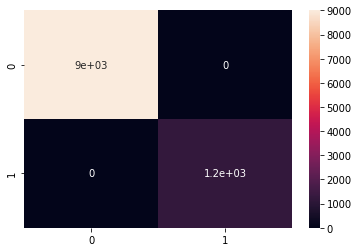

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(x_test)
y_pred = one_or_zero(y_pred)

cf_matrix = confusion_matrix(y_pred, y_test)
sns.heatmap(cf_matrix, annot=True)

[[9.9885738e-01]
 [6.4102042e-04]
 [9.9997759e-01]
 [9.9998987e-01]
 [1.0916777e-03]]
['kristo_jarvis.wav', 'kristo_2.wav', 'kristo_1.wav', 'kristo_3.wav', 'kristo_alexa.wav']


<AxesSubplot:>

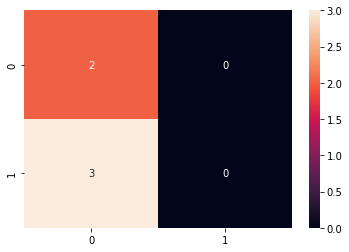

In [38]:
audio_dir_kristo = "./kristo/"
path_list_kristo = os.listdir(audio_dir_kristo)

kristo = []
for i in range(len(path_list_kristo)):
    tmp, sr = load_wav(audio_dir_kristo, path_list_kristo[i], DEFAULT_SR)
    kristo.append(tmp)

kristo = fix_length(kristo, max_length)

kristo_melsp = []
for i in range(len(kristo)):
    kristo_melsp.append(calculate_melsp(kristo[i]))

kristo_melsp = np.array(kristo_melsp)

result = model.predict(kristo_melsp)

print(result)
print(path_list_kristo)

result = one_or_zero(result)
cf_matrix = confusion_matrix(result, np.zeros(5))
sns.heatmap(cf_matrix, annot=True)

[[1.6224153e-10]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [9.9997187e-01]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]]
['peace.wav', 'yolo.wav', 'hello.wav', 'jarvis.wav', 'eo.wav', 'alexa.wav', 'yahoo.wav', 'okgoogle.wav']


<AxesSubplot:>

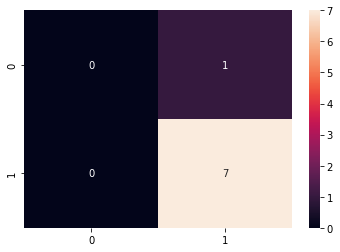

In [39]:
audio_dir_etc = "./test_mine/"
path_list_etc = os.listdir(audio_dir_etc)

etc = []
for i in range(len(path_list_etc)):
    tmp, sr = load_wav(audio_dir_etc, path_list_etc[i], DEFAULT_SR)
    etc.append(tmp)

etc = fix_length(etc, max_length)

etc_melsp = []
for i in range(len(etc)):
    etc_melsp.append(calculate_melsp(etc[i]))

etc_melsp = np.array(etc_melsp)

result = model.predict(etc_melsp)
print(result)
print(path_list_etc)
result = one_or_zero(result)
cf_matrix = confusion_matrix(result, np.ones(8))
sns.heatmap(cf_matrix, annot=True)